In [ ]:
from collections.abc import Sequence
import pathlib
import itertools
import itertools
import os
import re
from etils import epath
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import tqdm
from scipy import stats, signal
import geopandas as gpd
import xarray as xr
import joblib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches
from matplotlib import path

from neuralhydrology.datautils import utils
from neuralhydrology.evaluation import metrics

COLORS = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

def cohens_d(list_one: Sequence[float], list_two: Sequence[float]) -> float:
    """Calculate Cohen's d (effect size). """
    s = np.sqrt(((len(list_one) - 1) * np.var(list_one) + (len(list_two) - 1) * np.var(list_two)) /
                (len(list_one) + len(list_two) - 2))
    d = (np.abs(np.mean(list_one) - np.mean(list_two))) / s
    return d

# Load results

In [ ]:
sweep_dir = pathlib.Path('./results/nansweep_step_lr25_v2/')
drop_seq_dir = pathlib.Path('./results/drop-sequences/')

def parse_sweep_run_dir(run_dir):
  base_name = os.path.basename(run_dir)
  matches = re.fullmatch(
      '531_(\w+)_forcinggroups_seed(\d)_nanstep_use.*_nanprob0(\d+)_.*',
      base_name,
  )
  assert matches is not None, base_name
  typ = matches.group(1) + "_relu"
  seed = int(matches.group(2))
  nans = float(f'0.{matches.group(3)}')
  return (typ, nans, seed)

def parse_drop_seq_run_dir(run_dir, nan_step_prob=0.1):
  base_name = os.path.basename(run_dir)
  matches = re.fullmatch(
      f'531_(\w+)_forcinggroups_seed(\d).*',
      base_name,
  )
  assert matches is not None, base_name
  heads = re.fullmatch('.*num_heads(\d).*', base_name)
  typ = matches.group(1) + '_relu'
  seed = int(matches.group(2))
  return (typ, seed)

run_dirs_sweep = {
    parse_sweep_run_dir(r): r
    for r in sweep_dir.glob('*/531_*')
}
run_dirs_drop_seq = {
    parse_drop_seq_run_dir(r): r
    for r in drop_seq_dir.glob('531_*')
}
len(run_dirs_sweep), len(run_dirs_drop_seq)

(63, 9)

In [ ]:
def load_sweep_metrics(run_dir, epoch, metadata, period, metrics_string=''):
  metrics_dir = os.path.join(
      run_dir,
      period,
      f'model_epoch{epoch:03d}',
      f'{period}_{metrics_string}metrics.csv',
  )
  metrics = pd.read_csv(metrics_dir, dtype={'basin': str}, index_col='basin')
  metrics.index = pd.MultiIndex.from_tuples(
      [metadata + (basin,) for basin in metrics.index],
      names=('typ', 'nans', 'seed', 'basin'),
  )
  assert len(metrics) == 531
  return metrics


epochs = {'im_relu': 30, 'mme_relu': 35, 'attn_relu': 30}
period = 'test'
sweep_metrics = joblib.Parallel(n_jobs=8)(joblib.delayed(load_sweep_metrics)(
            run_dir=run_dir,
            epoch=epochs[metadata[0]],
            metadata=metadata,
            period=period,
        ) for metadata, run_dir in run_dirs_sweep.items())
keep_group_metrics = joblib.Parallel(n_jobs=8)(joblib.delayed(load_sweep_metrics)(
            run_dir=run_dir,
            epoch=epochs[metadata[0]],
            metadata=(metadata[0] + f'_keep{group}',) + (0.1, metadata[1]),
            period=period,
            metrics_string=f'keep{group}_',
        ) for group, (metadata, run_dir) in itertools.product(
            ['daymet', 'maurer', 'nldas', 'daymet_maurer', 'daymet_nldas', 'maurer_nldas'],
            run_dirs_drop_seq.items(),
        )
)
sweep_metrics = pd.concat(sweep_metrics)
sweep_hp_cols = ['typ', 'nans']
sweep_results = (
    sweep_metrics.groupby(sweep_hp_cols + ['basin'])
    .mean()
    .groupby(sweep_hp_cols)
    .median()
    .sort_index()
)
sweep_results

NSE       MSE      RMSE       KGE  Alpha-NSE  Pearson-r  \
typ       nans                                                                 
attn_relu 0.0   0.792367  1.275032  1.127029  0.788330   0.862913   0.900785   
          0.1   0.783630  1.360386  1.166106  0.774630   0.842304   0.894236   
          0.2   0.771436  1.418753  1.184563  0.762104   0.825623   0.889866   
          0.3   0.751784  1.551483  1.243125  0.744783   0.807786   0.879546   
          0.4   0.728689  1.669977  1.285275  0.724705   0.793592   0.867074   
          0.5   0.697907  1.872277  1.366990  0.700329   0.768078   0.850014   
          0.6   0.645365  2.165264  1.469905  0.667489   0.744530   0.817222   
im_relu   0.0   0.791819  1.248127  1.116378  0.791331   0.862569   0.899769   
          0.1   0.782298  1.321515  1.148151  0.786894   0.854567   0.894174   
          0.2   0.772516  1.390049  1.177483  0.774022   0.837888   0.888903   
          0.3   0.757884  1.502909  1.223823  0.750283   0.819265   0.880427   
          0.4   0.725424  1.631792  1.275516  0.730376   0.802651   0.865276   
          0.5   0.688494  1.874836  1.368765  0.696131   0.769370   0.845630   
          0.6   0.641279  2.224175  1.487835  0.645792   0.732192   0.813590   
mme_relu  0.0   0.789169  1.289617  1.135340  0.795083   0.872665   0.898464   
          0.1   0.782636  1.321972  1.149562  0.787847   0.863642   0.894267   
          0.2   0.769659  1.406074  1.185753  0.766543   0.833530   0.889324   
          0.3   0.752260  1.532432  1.236941  0.760151   0.832387   0.878504   
          0.4   0.729707  1.696888  1.302577  0.737849   0.809326   0.864815   
          0.5   0.696304  1.907592  1.380971  0.706051   0.779502   0.844898   
          0.6   0.646089  2.205035  1.477831  0.663246   0.749461   0.815874   

                Beta-KGE  Beta-NSE        FHV        FMS        FLV  \
typ       nans                                                        
attn_relu 0.0   0.935779 -0.032173 -13.895955  -5.061794 -13.003388   
          0.1   0.931935 -0.033846 -15.773204  -6.066994 -17.467964   
          0.2   0.932446 -0.034851 -17.249918  -5.199101 -10.167297   
          0.3   0.925886 -0.037530 -18.775794  -7.275631 -10.716351   
          0.4   0.924938 -0.038235 -20.600723  -7.584915 -11.602976   
          0.5   0.916472 -0.041453 -23.745893  -7.097754 -14.298946   
          0.6   0.923775 -0.035945 -25.708364 -11.387897  -7.774984   
im_relu   0.0   0.937931 -0.032938 -13.600649  -5.394815 -15.520949   
          0.1   0.939365 -0.031648 -14.319365  -5.912062 -14.421532   
          0.2   0.949338 -0.025065 -15.920836  -6.750313 -22.425720   
          0.3   0.933131 -0.033024 -18.400625  -7.242758 -23.255123   
          0.4   0.931523 -0.034368 -19.585689  -8.085535 -27.229069   
          0.5   0.925610 -0.036347 -23.256060  -9.612173 -24.693881   
          0.6   0.915471 -0.041507 -27.303155 -12.214741 -26.239112   
mme_relu  0.0   0.945343 -0.027141 -12.727791  -6.491586 -17.264637   
          0.1   0.947515 -0.025630 -13.627532  -5.030740 -20.140901   
          0.2   0.931927 -0.033659 -16.216630  -5.941858 -30.018487   
          0.3   0.942886 -0.026648 -17.034144  -4.674894 -19.234963   
          0.4   0.938450 -0.032492 -18.975943  -6.205294 -24.997042   
          0.5   0.927546 -0.035591 -22.261505  -7.655187 -17.739161   
          0.6   0.920757 -0.036767 -25.325198  -9.998428 -19.042391   

                Peak-Timing  Missed-Peaks  Peak-MAPE  
typ       nans                                        
attn_relu 0.0      0.280702      0.355932  35.340982  
          0.1      0.296296      0.360544  36.749138  
          0.2      0.333333      0.368421  37.489653  
          0.3      0.368421      0.375758  38.877855  
          0.4      0.388889      0.384058  41.218857  
          0.5      0.450000      0.406061  44.445636  
          0.6      0.511111      0.428571  48.236510  
im_relu   0.0      0.271605      0.350877  35.80879

## Load baselines

In [ ]:
baselines_dir = pathlib.Path('./results/baselines/kratzert_synergy/')
baselines_files = {
    'all': sorted(baselines_dir.glob('cudalstm_all_forcings_seed*/test_results_epoch030.nc')),
    'daymet': sorted(baselines_dir.glob('cudalstm_daymet_seed*/test_results_epoch030.nc')),
    'maurer': sorted(baselines_dir.glob('cudalstm_maurer_seed*/test_results_epoch030.nc')),
    'nldas': sorted(baselines_dir.glob('cudalstm_nldas_seed*/test_results_epoch030.nc')),
    'daymet_maurer': sorted(baselines_dir.glob('cudalstm_maurer_daymet_seed*/test_results_epoch030.nc')),
    'daymet_nldas': sorted(baselines_dir.glob('cudalstm_nldas_daymet_seed*/test_results_epoch030.nc')),
    'maurer_nldas': sorted(baselines_dir.glob('cudalstm_nldas_maurer_seed*/test_results_epoch030.nc')),
}

def load_baseline_metrics(name, results_file):
  seed = re.fullmatch('.*_seed(\d+)_.*', results_file).group(1)
  with open(results_file, 'rb') as f:
    baseline_results = xr.load_dataset(f).isel(time_step=-1)
    baseline_metrics = {
        (name, 0.0, int(seed), basin): metrics.calculate_metrics(
            baseline_results['QObs(mm/d)_obs'].sel(basin=basin),
            baseline_results['QObs(mm/d)_sim'].sel(basin=basin),
            metrics=metrics.get_available_metrics(),
            resolution='1D',
        )
        for basin in baseline_results['basin'].values
    }
  ret = pd.DataFrame(baseline_metrics).T
  ret.index.names = ['typ', 'nans', 'seed', 'basin']
  return ret

# # Use this to calculate metrics from scratch:
# baseline_metrics = pd.concat(
#     joblib.Parallel(n_jobs=4, verbose=11)(joblib.delayed(load_baseline_metrics)(
#         name=name, results_file=file
#     ) for name, name_files in baselines_files.items() for file in name_files
#   )
# )
# baseline_metrics = baseline_metrics.sort_index()
# with open(baselines_dir / "baseline_metrics_3seeds.csv", "w") as f:
#   baseline_metrics.to_csv(f)
with open(baselines_dir / "baseline_metrics_3seeds.csv", "r") as f:
  baseline_metrics = pd.read_csv(f, index_col=[0, 1, 2, 3], dtype={"basin": str})
baseline_metrics

NSE        MSE      RMSE       KGE  \
typ   nans seed   basin                                               
all   0.0  168389 01022500  0.897911   0.502634  0.708967  0.914806   
                  01031500  0.896017   0.976820  0.988342  0.924993   
                  01047000  0.868504   1.403359  1.184635  0.911183   
                  01052500  0.872848   1.665223  1.290435  0.891931   
                  01054200  0.779309   6.504303  2.550353  0.763393   
...                              ...        ...       ...       ...   
nldas 0.0  258357 14309500  0.813361   5.128294  2.264574  0.752661   
                  14316700  0.839593   4.436698  2.106347  0.728923   
                  14325000  0.862822   8.305735  2.881967  0.831693   
                  14362250  0.840863   0.183863  0.428792  0.703541   
                  14400000  0.887279  20.679969  4.547523  0.877406   

                            Alpha-NSE  Pearson-r  Beta-KGE  Beta-NSE  \
typ   nans seed   basin                                                
all   0.0  168389 01022500   0.961986   0.949064  1.056731  0.051420   
                  01031500   0.979611   0.947652  1.049699  0.031708   
                  01047000   0.958143   0.932648  0.959998 -0.026054   
                  01052500   0.930453   0.934827  0.949061 -0.032168   
                  01054200   0.792194   0.888005  0.983992 -0.008000   
...                               ...        ...       ...       ...   
nldas 0.0  258357 14309500   0.784892   0.911745  0.915645 -0.042725   
                  14316700   0.745112   0.937068  0.932512 -0.040697   
                  14325000   0.845892   0.932969  0.990806 -0.005183   
                  14362250   0.727225   0.942560  0.899093 -0.034461   
                  14400000   0.907780   0.943227  0.942542 -0.033773   

                                  FHV        FMS         FLV  Peak-Timing  \
typ   nans seed   basin                                                     
all   0.0  168389 01022500  -5.213829  -8.158453   24.184956     0.260870   
                  01031500   1.151158 -16.937092 -421.060837     0.272727   
                  01047000  -2.081556 -10.356185 -916.150565     0.136364   
                  01052500  -6.708064 -13.456673   16.352876     0.090909   
                  01054200 -22.600063 -11.056727   22.100957     0.090909   
...                               ...        ...         ...          ...   
nldas 0.0  258357 14309500 -25.719699  -4.230043   48.585074     0.153846   
                  14316700 -29.457662 -12.340624  -32.436653     0.473684   
                  14325000 -19.072799 -13.625552   70.901449     0.125000   
                  14362250 -24.272325 -24.998574   91.637445     0.000000   
                  14400000  -6.822608   9.226664   19.035744     0.400000   

                            Missed-Peaks  Peak-MAPE  
typ   nans seed   basin                              
all   0.0  168389 01022500      0.288889  16.589564  
                  01031500      0.360000  19.076549  
                  01047000      0.296296  26.037420  
                  01052500      0.372881  24.789643  
                  01054200      0.385965  35.186329  
...                                  ...        ...  
nldas 0.0  258357 14309500      0.394737  28.132519  
                  14316700      0.382979  35.147886  
                  14325000      0.354167  36.127083  
                  14362250      0.428571  33.231780  
                  14400000      0.400000  28.066762  

[11151 rows x 14 columns]

# Plots

## Experiment 1

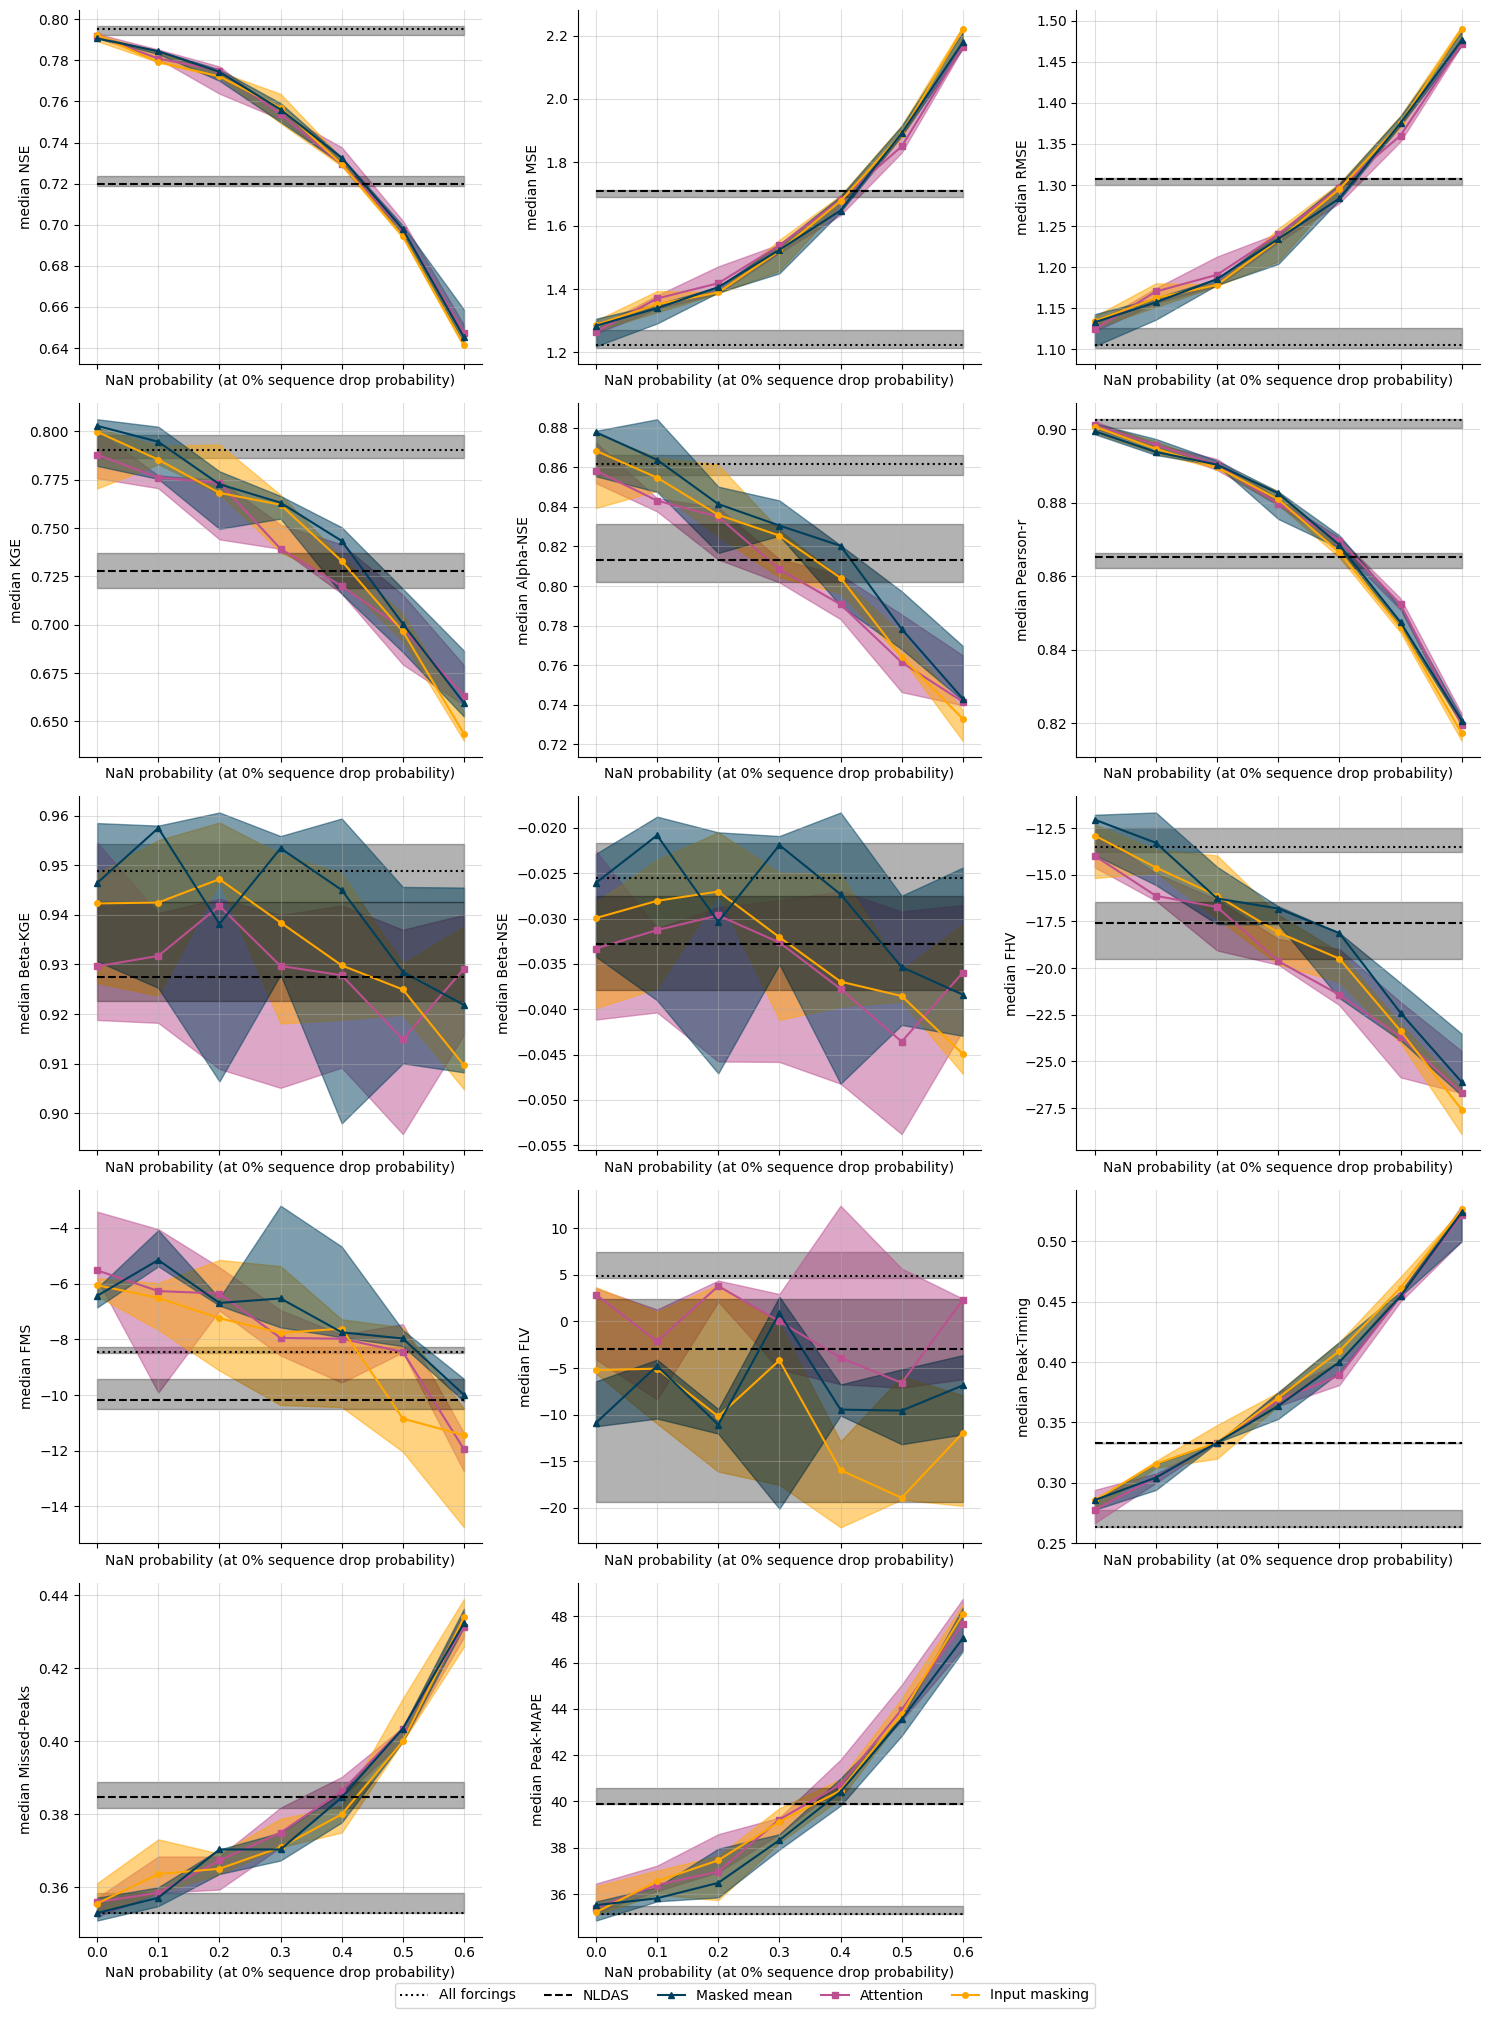

In [ ]:
wide_sweep_results = (
    pd.concat([sweep_metrics, baseline_metrics])
    .groupby(sweep_hp_cols + ['seed'])
    .median()
    .unstack(level='nans')
)
wide_sweep_results = wide_sweep_results.groupby('typ').agg(
    ['min', 'median', 'max']
)
labels = {
    'mme_relu': 'Masked mean',
    'im_relu': 'Input replacing',
    'attn_relu': 'Attention',
    'nldas': 'NLDAS',
    'all': 'All forcings',
}
metrics = sweep_metrics.columns
f, axs = plt.subplots(5, 3, figsize=(15, 20), sharex=True, sharey=False)
for ax, metric in zip(axs.flatten(), metrics):
  for i, (index, vals) in enumerate(wide_sweep_results.loc[:, (metric, slice(None), slice(None))].iterrows()):
    if index in ['all', 'nldas']:
      baseline_vals = vals.loc[(metric, 0.0, slice(None))]
      nans = np.unique(sweep_results.index.get_level_values('nans'))
      ax.plot(
          nans,
          [baseline_vals.loc['median'].item()] * len(nans),
          label=labels.get(index, index) if ax==axs[0,0] else None,
          ls=':' if index == 'all' else '--',
          color='black',
      )
      ax.fill_between(
          nans,
          [baseline_vals.loc['min'].item()] * len(nans),
          [baseline_vals.loc['max'].item()] * len(nans),
          alpha=0.3,
          color='black',
      )
    if index in ['mme_relu', 'im_relu', 'attn_relu']:
      c = {'im_relu': COLORS[-1], 'mme_relu': COLORS[0], 'attn_relu': COLORS[2]}[index]
      m = {'im_relu': 'o', 'mme_relu': '^', 'attn_relu': 's'}[index]
      ax.plot(
          vals.loc[(metric, slice(None), 'median')],
          label=labels.get(index, index) if ax==axs[0,0] else None,
          marker=m,
          ms=4,
          color=c,
      )
      ax.fill_between(
          vals.index.levels[1],
          vals.loc[(metric, slice(None), 'min')],
          vals.loc[(metric, slice(None), 'max')],
          alpha=0.5,
          color=c,
      )
  ax.spines[['right', 'top']].set_visible(False)
  ax.set_xlabel('NaN probability (at 0% sequence drop probability)')
  ax.set_ylabel(f'median {metric}')
  ax.grid(alpha=0.4)
for ax in axs.flatten()[len(metrics):]:
  ax.axis('off')
f.patch.set_facecolor('white')
handles, legend_labels = axs[0, 0].get_legend_handles_labels()
order = [0, 4, 3, 1, 2]
plt.figlegend([handles[idx] for idx in order], [legend_labels[idx] for idx in order], ncols=5, loc='lower center', bbox_to_anchor=(0.5, -0.01))
plt.tight_layout()

### Visualize Attention

In [ ]:
usa = gpd.read_file('./results/us_shp/tl_2024_us_state.shp')
usa = usa[~usa['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico', 'Guam', 'American Samoa', 'Commonwealth of the Northern Mariana Islands', 'United States Virgin Islands'])]
usa = usa.simplify(0.05)
usa = usa.to_crs('ESRI:102003')

gdf = gpd.read_file('./results/camels.geojson').set_index('index')
gdf.index.name = 'basin'

attn_run_dirs = sweep_dir.glob('attn/531_attn_forcinggroups_seed*_nanprob00_*/test/model_epoch030/test_all_output.p')
attn_results = []
for file in attn_run_dirs:
  with open(file, 'rb') as f:
    attn_results.append(pickle.load(f))

attn_weights = []
for i, attn_results_i in enumerate(attn_results):
  attn_weights.append({})
  for basin, basin_results in tqdm.tqdm(attn_results_i.items()):
    mean_attn_weights = np.mean(basin_results['attention_weights'], axis=0)
    attn_weights[-1][basin] = {}
    for day in range(1, mean_attn_weights.shape[0] + 1):
      for j, product in enumerate(['daymet', 'nldas', 'maurer']):
        attn_weights[-1][basin][product + f'-{day}-seed{i}'] = mean_attn_weights[-day, j]
  attn_weights[-1] = pd.DataFrame(attn_weights[-1]).T
attn_weights = pd.concat(attn_weights, axis=1)

# Make the plots nicer.
gdf = gdf.to_crs("ESRI:102003")
gdf = gdf.join(attn_weights)
for seed, day in itertools.product([0, 1, 2], range(1, 15)):
  gdf[f'max-{day}-seed{seed}'] = gdf[[f'daymet-{day}-seed{seed}', f'nldas-{day}-seed{seed}', f'maurer-{day}-seed{seed}']].idxmax(axis=1)
gdf = gdf.sample(100, random_state=0)

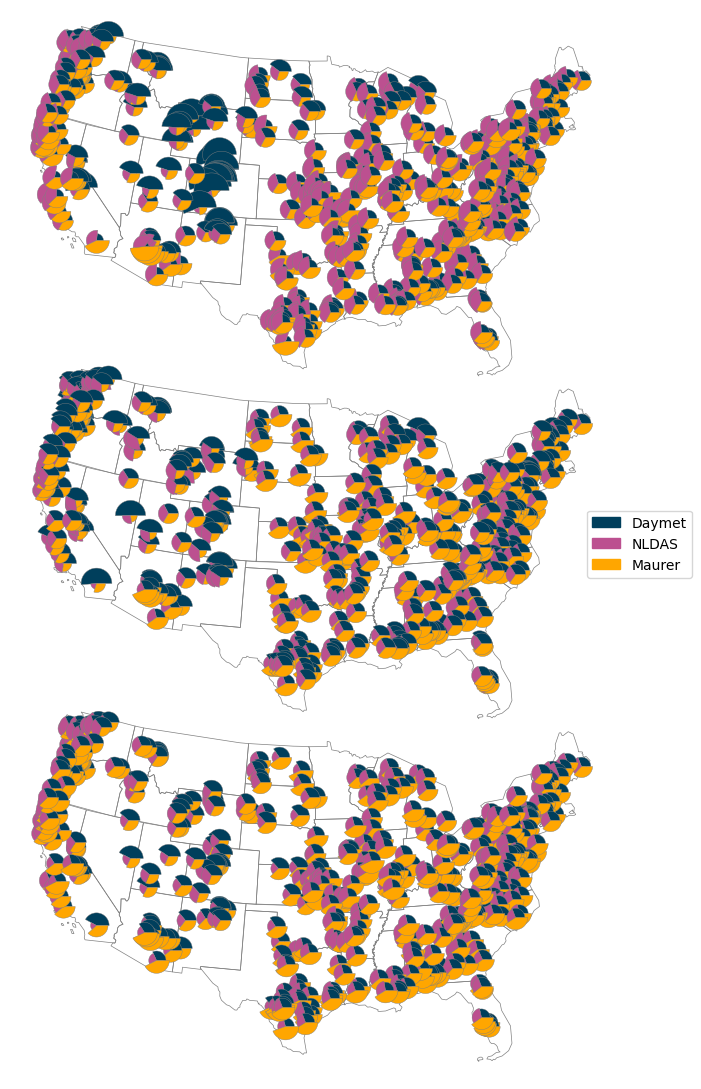

In [ ]:
# Thanks https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib

buf = 100
xlim, ylim = list(zip(usa.buffer(buf).bounds[["minx", "miny"]].min(), usa.buffer(buf).bounds[["maxx", "maxy"]].max()))

def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    assert sum(ratios) <= 1+1e-6, 'sum of ratios needs to be < 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 50)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 50)).tolist() + [0]
        xy = np.column_stack([x, y])*(2.5*ratio)
        previous = this
        markers.append({'marker': xy, 's': np.abs(xy).max()**2*np.array(sizes),
                        'facecolor': color, 'edgecolor': 'gray', 'linewidth': 0.3})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker)

colors = [COLORS[0], COLORS[2], COLORS[-1]]
xlabels = ['Daymet','NLDAS','Maurer']
f, axs = plt.subplots(3, 1, figsize=(7, 11), sharex=True, sharey=True)
for seed, ax in zip([0, 1, 2], axs):
  ax.set_axis_off()
  usa.boundary.plot(edgecolor='gray', linewidth=.5, ax=ax, zorder=-9)

  for ix, lon1, lat1 in zip(gdf.index, gdf.gauge_lon, gdf.gauge_lat):
      geom = gdf.loc[ix].geometry.xy
      bdata = gdf.loc[ix][[f"daymet-1-seed{seed}", f"nldas-1-seed{seed}", f"maurer-1-seed{seed}"]].values
      assert bdata.sum() > 1-1e-4 and bdata.sum() < 1+1e-4
      bax = drawPieMarker([geom[0][0]], [geom[1][0]], bdata/bdata.sum(), [400], colors=colors, ax=ax)

  patch0 = mpatches.Patch(color=colors[0], label='Daymet')
  patch1 = mpatches.Patch(color=colors[1], label='NLDAS')
  patch2 = mpatches.Patch(color=colors[2], label='Maurer')
  ax.relim()
  ax.autoscale_view(tight=True)
plt.figlegend(ncols=1, handles=[patch0, patch1, patch2], loc='center right', bbox_to_anchor=(1.05, 0.5))
f.patch.set_facecolor('white')
plt.tight_layout(h_pad=-3, w_pad=0)

## Experiment 2

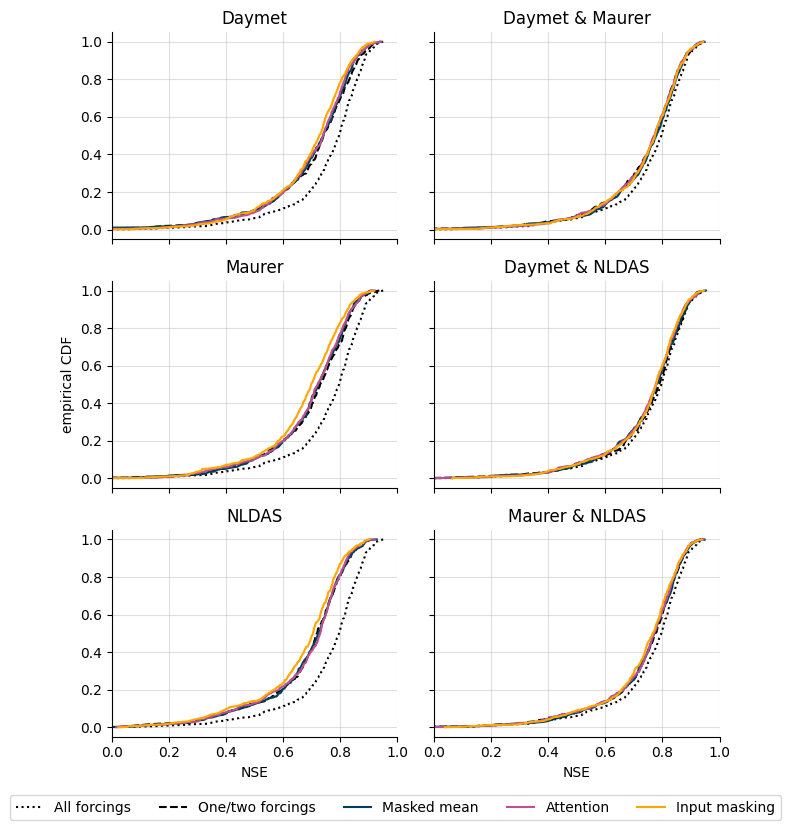

In [ ]:
keep_group_results = (
    pd.concat(keep_group_metrics + [baseline_metrics[["NSE"]]])
    .groupby(sweep_hp_cols + ['basin'])
    .mean()
    .unstack(level='basin')
)
keep_group_results.columns = keep_group_results.columns.droplevel(0)
keep_group_results.reset_index('nans', drop=True, inplace=True)
labels = {
    'mme_relu': 'Masked mean',
    'attn_relu': 'Attention',
    'im_relu': 'Input replacing',
    '': 'One/two forcings',
    'all': 'All forcings',
}
keeplabel = {
    'daymet': 'Daymet',
    'maurer': 'Maurer',
    'nldas': 'NLDAS',
    'daymet_maurer': 'Daymet & Maurer',
    'daymet_nldas': 'Daymet & NLDAS',
    'maurer_nldas': 'Maurer & NLDAS',
}
f, all_axs = plt.subplots(3, 2, figsize=(7, 8), sharex=True, sharey=True)
all_axs = all_axs.T
vals = keep_group_results.loc['all']
for i, ax in enumerate(all_axs.flatten()):
  ax.plot(
          vals.sort_values(),
          np.linspace(0, 1, len(vals)),
          label='All forcings' if i == 0 else None,
          c='black',
          ls=':',
      )
  ax.grid(alpha=.4)
  ax.set_xlim(0, 1)
  ax.spines[['right', 'top']].set_visible(False)
  if i == 1:
    ax.set_ylabel('empirical CDF')
  if i in [2, 5]:
    ax.set_xlabel('NSE')
col = 0
for keep_1 in [None, 'daymet', 'maurer', 'nldas']:
  for keep_2 in ['daymet', 'maurer', 'nldas']:
    if keep_1 is not None and keep_1 >= keep_2:
      continue
    row = int(keep_1 is not None)
    for typ in ['', 'mme_relu', 'attn_relu', 'im_relu']:
      c = {
          'im_relu': COLORS[-1],
          'mme_relu': COLORS[0],
          'attn_relu': COLORS[2],
          '': 'black',
          'all': 'black',
      }[typ]
      ls = '-' if 'im' in typ or 'mme' in typ or 'attn' in typ else '--'
      keep_name = f'{keep_1}_{keep_2}' if keep_1 is not None else keep_2
      if not typ:
        idx = keep_name
      else:
        idx = f'{typ}_keep{keep_name}'
      vals = keep_group_results.loc[idx]
      all_axs[row, col].plot(
          vals.sort_values(),
          np.linspace(0, 1, len(vals)),
          label=labels.get(typ) if col == row == 0 else None,
          c=c,
          ls=ls,
      )
      all_axs[row, col].set_title(keeplabel[keep_name])
    col = (col + 1) % 3

f.patch.set_facecolor('white')
plt.figlegend(ncols=5, loc='lower center', bbox_to_anchor=(0.5, -0.04))
plt.tight_layout()

## Experiment 3

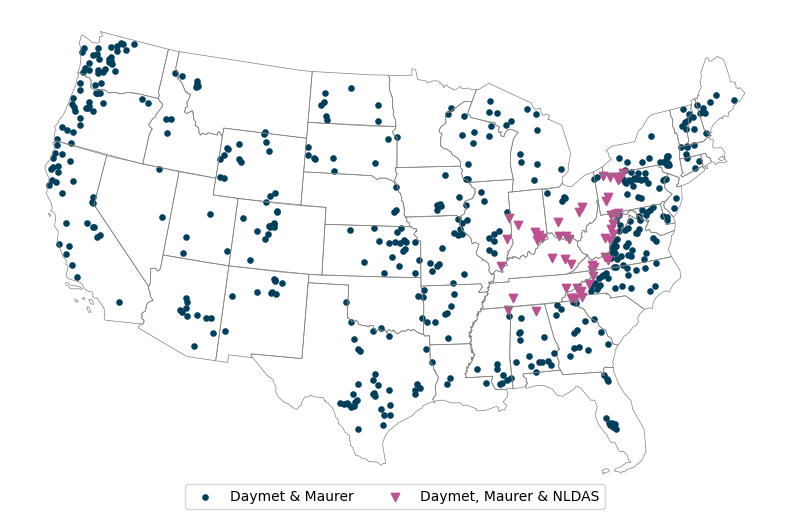

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(8, 6))
usa.boundary.plot(edgecolor='gray', linewidth=.5, ax=ax)
cond = (gdf.index.str.startswith("03"))
region = gdf[cond].index.tolist()
gdf[~(cond)].plot(ax=ax, color=COLORS[0], marker='o', label='Daymet & Maurer', markersize=14)
gdf[cond].plot(ax=ax, color=COLORS[2], marker='v', label='Daymet, Maurer & NLDAS')
ax.axis('off')
ax.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5, -0.04))
f.patch.set_facecolor('white')
plt.tight_layout()

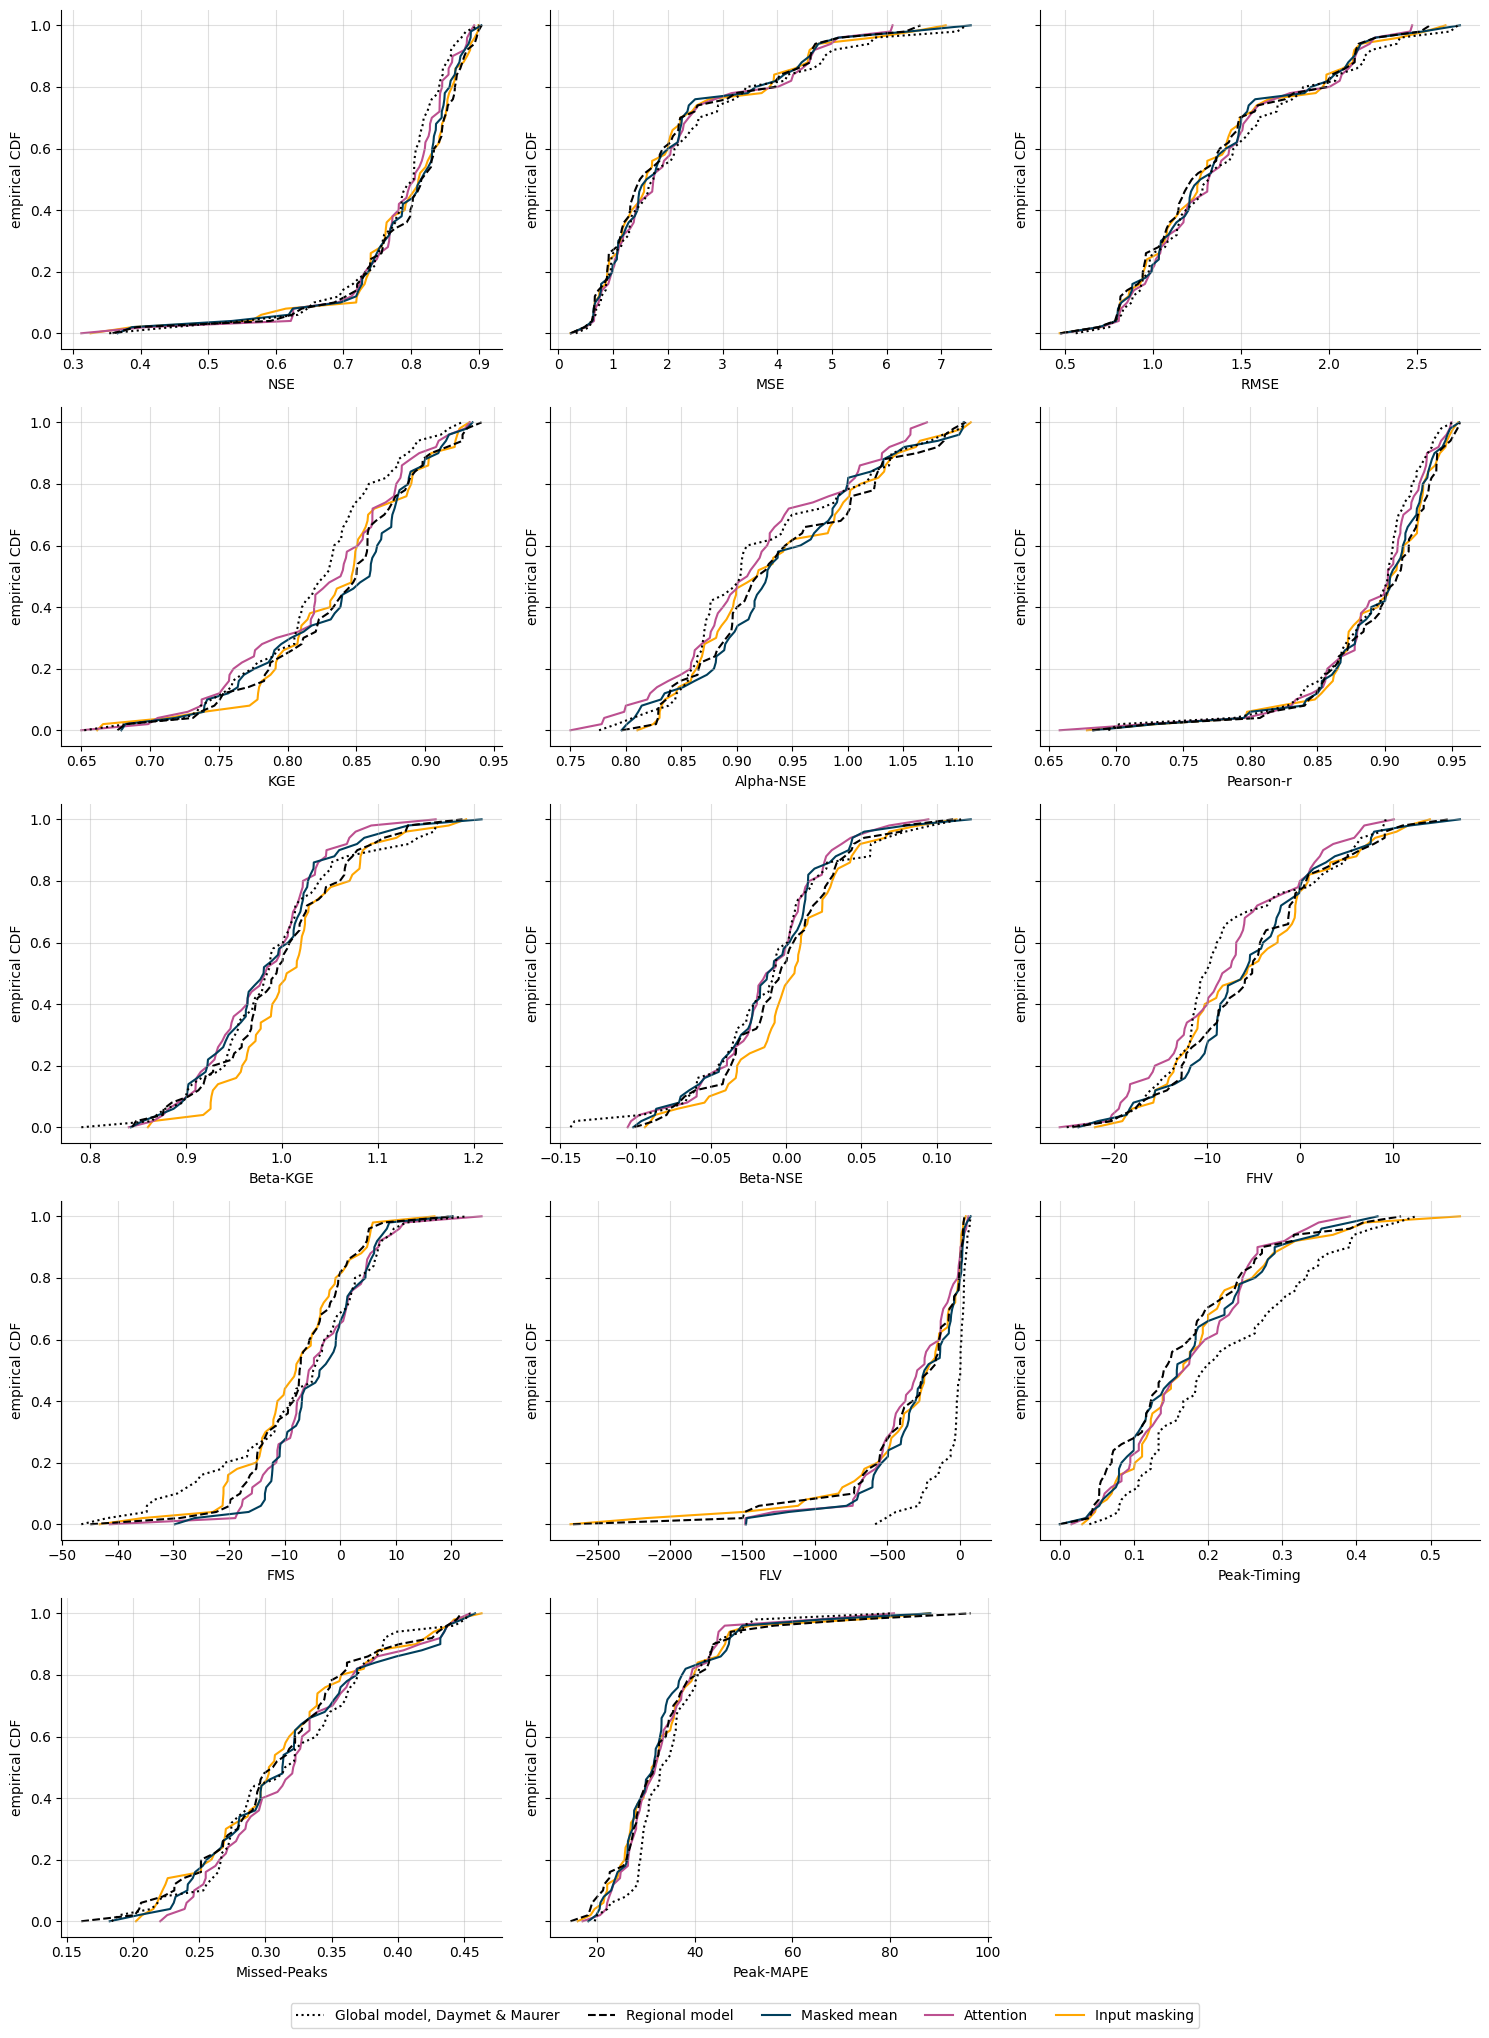

In [ ]:
regional_dir = pathlib.Path('./results/regional/nldas_huc3/')
def parse_regional_run_dir(run_dir):
  matches = re.fullmatch('.*531_nldashuc3_(\w+)_forcinggroups_seed(\d).*', str(run_dir))
  assert matches is not None
  typ = matches.group(1) + '_relu'
  seed = int(matches.group(2))
  return typ, seed

run_dirs_regional = {parse_regional_run_dir(r): r for r in regional_dir.glob('531_nldashuc3_*_forcinggroups_seed*')} \
  | {('all', int(str(r).split('_seed')[1][0])): r for r in regional_dir.glob('baselines/multiforcing*seed*')}

def load_regional_metrics(run_dir, epoch, metadata, period):
  metrics_dir = os.path.join(
      run_dir,
      period,
      f'model_epoch{epoch:03d}',
      f'{period}_metrics.csv',
  )
  metrics = pd.read_csv(metrics_dir, dtype={'basin': str}, index_col='basin')
  metrics.index = pd.MultiIndex.from_tuples(
      [metadata + (basin,) for basin in metrics.index],
      names=('typ', 'seed', 'basin'),
  )
  assert len(metrics) == 531
  return metrics


epochs = {'im_relu': 30, 'mme_relu': 35, 'attn_relu': 30, 'all': 30}
period = 'test'
regional_metrics = joblib.Parallel(n_jobs=8)(joblib.delayed(load_regional_metrics)(
            run_dir=run_dir,
            epoch=epochs[metadata[0]],
            metadata=metadata,
            period=period,
        ) for metadata, run_dir in run_dirs_regional.items()
)
regional_metrics = pd.concat(regional_metrics)
regional_metrics_region = regional_metrics.loc[(slice(None), slice(None), region)].sort_index()
c = {'mme_relu': COLORS[0], 'attn_relu': COLORS[2], 'im_relu': COLORS[-1], 'all': 'black'}
labels = {'mme_relu': 'Masked mean', 'attn_relu': 'Attention', 'im_relu': 'Input replacing', 'all': 'Regional model'}
metrics = baseline_metrics.columns
f, axs = plt.subplots(5, 3, figsize=(15, 20), sharey=True)
for ax, metric in zip(axs.flatten(), metrics):
  ax.plot(baseline_metrics.loc[('daymet_maurer', 0.0), metric].groupby('basin').mean().loc[region].sort_values(), np.linspace(0, 1, len(region)), label='Global model, Daymet & Maurer' if ax==axs[0,0] else None, color='black', ls=':', zorder=999)
  for i, typ in enumerate(['all', 'mme_relu', 'attn_relu', 'im_relu']):
    ax.plot(regional_metrics_region.loc[typ, metric].groupby(['basin']).mean().sort_values(), np.linspace(0, 1, len(region)),
            label=labels.get(typ) if ax==axs[0,0] else None, color=c[typ],
            ls='--' if typ == 'all' else '-', zorder=-i)
  ax.spines[['right', 'top']].set_visible(False)
  ax.set_xlabel(metric)
  ax.set_ylabel('empirical CDF')
  ax.grid(alpha=0.4)
f.patch.set_facecolor('white')
axs.flatten()[-1].axis('off')
plt.figlegend(ncols=5, loc='lower center', bbox_to_anchor=(0.5, -0.02))
plt.tight_layout()